In [7]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import yaml
from timeit import default_timer as timer

mnist = tf.keras.datasets.mnist

In [2]:
# Load data from mnist into train set and test set
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
# Turn data into one dimensional array (for KMeans fitting)
train_features = np.array([np.concatenate(i) for i in x_train])

test_features = np.array([np.concatenate(i) for i in x_test])
test_set = np.hstack((test_features, np.resize(y_test, (test_features.shape[0], 1))))

# print(train_set[0])

In [4]:
n_clusters = len(set(y_train))
classes = [[] for i in range(n_clusters)]
for i in range(n_clusters):
    classes[i] = train_features[np.where(y_train == i)]

In [5]:
# test if classes are ok
# plt.imshow(np.resize(classes[6][6],(28,28)))

In [19]:

# Creates clusters in each class, reducing number of points of data set
for new_data_len in range(160, 210, 10):
    start = timer()
    clustering = []
#     new_data_len = 40
    for item in classes:
        clustering.append(KMeans(n_clusters = new_data_len, random_state = 0).fit(item))
    end = timer()
    print(f'Elapsed time: {end - start} seconds')
    with open(f'classes_{new_data_len}.yaml', 'w') as f:
            yaml.dump(clustering, f)

Elapsed time: 453.44806557099946 seconds
Elapsed time: 473.0130165349992 seconds
Elapsed time: 501.4398306659996 seconds
Elapsed time: 545.7143996859995 seconds
Elapsed time: 546.1405777980008 seconds


In [7]:
%%time
# Creates clusters in each class, reducing number of points of data set
for new_data_len in [500]:
    clustering = []
#     new_data_len = 40
    for item in classes:
        clustering.append(KMeans(n_clusters = new_data_len, random_state = 0).fit(item))

    with open(f'classes_{new_data_len}.yaml', 'w') as f:
            yaml.dump(clustering, f)

CPU times: user 44min 46s, sys: 12min 33s, total: 57min 19s
Wall time: 19min 5s


In [32]:
# test if new classes are ok
# plt.imshow(np.resize(new_x_train_set[99], (28,28)))

In [5]:
def calc_disp_matrix(dataset):
    x = dataset - calc_mean(dataset)
    return np.dot(x.T, x)

def calc_cov_matrix(dataset):
    n = len(dataset)
    return calc_disp_matrix(dataset)/(n-1)

def calc_mean(dataset):
    return np.mean(dataset, axis=0)

def log_discriminant(sample, class_mean, class_cov, class_prob):
    cov_inv = np.linalg.inv(class_cov)
    g = -0.5*np.dot(np.dot((sample - class_mean), cov_inv), (sample - class_mean).T) - 0.5*np.log(np.linalg.det(class_cov)) + np.log(class_prob)
    
    return g

def bayesian_classifier(training_set, sample):
    data = training_set[:, 0:-1]
    labels = training_set[:,-1]
    print(data)
    print(labels)
    
    classes = set([int(i) for i in labels])
    set_size = len(data)
    g = [[] for i in classes]
    
    for i in classes:
        p_priori = len(data[np.where(labels == i)])/set_size
        g[i] = log_discriminant(sample, calc_mean(data[np.where(labels == i)]), calc_cov_matrix(data[np.where(labels == i)]), p_priori)
#         print(f'g[{i}] = {g[i]}')
#         print(g[i])
    
    return np.argmax(np.array(g))

def most_common(lst):
    return max(set(lst), key=lst.count)

def knn(dataset, sample, k):
    #dataset: (attributes, class labels)
    data = dataset[:, 0:-1]
    labels = dataset[:, -1]
    test_sample = np.array(sample)
    
    total_dist = data - test_sample                          # numpy automatically creates a repeated array of test_sample
    norm = np.sum(total_dist*total_dist, axis=1)
    neighbors = list(zip(norm, labels))                      # create list of tuples (square of distance, label of class)
    neighbors = sorted(neighbors, key=lambda tup: tup[0])    # sort neighbors by distance
    closest_n = [atribute[1] for atribute in neighbors[:k]]
    return most_common(closest_n)

def evaluate_error(classifier, training, test, extrArgs = []):
    error_rate = 0
    
    for sample in test:
        if classifier == knn:
            n = classifier(training, sample[:-1], extrArgs[0])
        else:
            n = classifier(training, sample[:-1])
        error_rate += not(n == sample[-1])
        
    return error_rate/len(test)

def split_folds(dataset, k):
    data_cpy = dataset.copy()
    np.random.shuffle(data_cpy)            # desordena conjunto de dados
    folds = np.split(data_cpy, k)          # divide os grupos
    return folds

def kfolds(classifier, dataset, k, extrArgs = []):
    folds = split_folds(dataset, k)
    error_array = []

    for i, fold in enumerate(folds):
        folds_cpy = folds.copy()           # cria cópia dos grupos
        test = folds_cpy.pop(i)            # separa grupo i para teste
        training = np.vstack(folds_cpy)    # agrupa demais grupos para treinamento
        error_array = np.append(error_array, evaluate_error(classifier, training, test, extrArgs))
    
    return np.mean(error_array), np.std(error_array)

In [61]:
%%time
kfolds_e = []

for new_data_len in range(50, 210, 10):
    print(f'K = {new_data_len}')
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1
#     plt.imshow(np.resize(new_x_train_set, (28, 28)))
    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))


    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    # training_set = np.hstack((train_set, np.resize(y_train, (x_train.shape[0], 1))))
    
#     print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')
#     print(f'K = {new_data_len}, k = 5, KNN error rate {kfolds(knn, training_set, 10, [5])}')
#     for k in range(1,12):
    k = 5
    e, var = kfolds(knn, training_set, 10, [k])
    print(f'\tk = {k}, KNN error rate {(e, var)}')
    kfolds_e.append(e)
    print()

K = 50
	k = 5, KNN error rate ([0.0679, 0.0601, 0.0566, 0.0523, 0.0523, 0.0495, 0.05, 0.0485, 0.0497, 0.0433, 0.0437, 0.0437, 0.0426, 0.0427, 0.0416], 0.01833030277982336)

K = 60
	k = 5, KNN error rate ([0.0679, 0.0601, 0.0566, 0.0523, 0.0523, 0.0495, 0.05, 0.0485, 0.0497, 0.0433, 0.0437, 0.0437, 0.0426, 0.0427, 0.0416], 0.021343747458109495)

K = 70
	k = 5, KNN error rate ([0.0679, 0.0601, 0.0566, 0.0523, 0.0523, 0.0495, 0.05, 0.0485, 0.0497, 0.0433, 0.0437, 0.0437, 0.0426, 0.0427, 0.0416], 0.014285714285714285)

K = 80
	k = 5, KNN error rate ([0.0679, 0.0601, 0.0566, 0.0523, 0.0523, 0.0495, 0.05, 0.0485, 0.0497, 0.0433, 0.0437, 0.0437, 0.0426, 0.0427, 0.0416], 0.01375)

K = 90
	k = 5, KNN error rate ([0.0679, 0.0601, 0.0566, 0.0523, 0.0523, 0.0495, 0.05, 0.0485, 0.0497, 0.0433, 0.0437, 0.0437, 0.0426, 0.0427, 0.0416], 0.01590869007030706)

K = 100
	k = 5, KNN error rate ([0.0679, 0.0601, 0.0566, 0.0523, 0.0523, 0.0495, 0.05, 0.0485, 0.0497, 0.0433, 0.0437, 0.0437, 0.0426, 0.0427, 0.

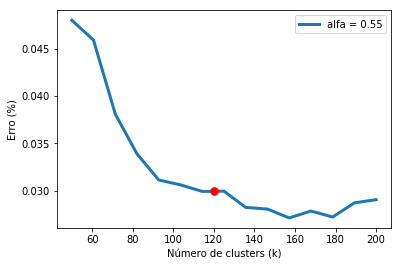

In [100]:
K = np.linspace(50,200,15)
plt.plot(K, calc_exp_error(kfolds_e, 0.55), label='alfa = 0.55', linewidth = 3)
plt.plot(120, calc_exp_error(kfolds_e, 0.55)[6], 'r.', markersize=15)
plt.ylabel('Erro (%)')
plt.xlabel('Número de clusters (k)')
plt.legend()
plt.savefig('kfolds_error.png')
plt.show()

In [105]:
error_eval = calc_exp_error(kfolds_e, 0.55)

lst_e = error_eval[0]
K = 50

for e in error_eval[1:]:
    K += 10
    print(f'lst = {lst_e}, e = {e}')
    if abs(e-lst_e) < 0.05*lst_e:
        print(K)
    lst_e = e

lst = 0.048, e = 0.0459
60
lst = 0.0459, e = 0.03810214285714286
lst = 0.03810214285714286, e = 0.03389367857142858
lst = 0.03389367857142858, e = 0.03114152321428572
lst = 0.03114152321428572, e = 0.030627837767857147
100
lst = 0.030627837767857147, e = 0.029936219863230522
110
lst = 0.029936219863230522, e = 0.029964920924776785
120
lst = 0.029964920924776785, e = 0.028249937277858003
lst = 0.028249937277858003, e = 0.028073179788536184
140
lst = 0.028073179788536184, e = 0.0271402488836949
150
lst = 0.0271402488836949, e = 0.027864636886032194
160
lst = 0.027864636886032194, e = 0.02723731499320006
170
lst = 0.02723731499320006, e = 0.028730523246260034
lst = 0.028730523246260034, e = 0.029064945680179862
190


In [23]:
# %%time

error = []
for new_data_len in range(50, 200, 10):
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1
    
    start = timer()
    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    e = evaluate_error(knn, training_set, test_set, [5])
    print(f'K={new_data_len}, {e}')
    end = timer()
    error.append(e)
    print(f'Elapsed time: {end - start} seconds')

K=50, 0.0679
Elapsed time: 14.402683285999956 seconds
K=60, 0.0601
Elapsed time: 19.194661873998484 seconds
K=70, 0.0566
Elapsed time: 26.17538942000101 seconds
K=80, 0.0523
Elapsed time: 28.910338663999937 seconds
K=90, 0.0523
Elapsed time: 32.21948290399996 seconds
K=100, 0.0495
Elapsed time: 35.23280621499907 seconds
K=110, 0.05
Elapsed time: 38.451435847999164 seconds
K=120, 0.0485
Elapsed time: 44.78823779300001 seconds
K=130, 0.0497
Elapsed time: 51.018001876998824 seconds
K=140, 0.0433
Elapsed time: 53.875961505000305 seconds
K=150, 0.0437
Elapsed time: 55.146669968000424 seconds
K=160, 0.0437
Elapsed time: 57.12223619499855 seconds
K=170, 0.0426
Elapsed time: 62.37483142500059 seconds
K=180, 0.0427
Elapsed time: 65.34014332100014 seconds
K=190, 0.0416
Elapsed time: 70.47852797999985 seconds


### usar erro médio exponencial

ei+1 = (1-y)eatual + yei

In [48]:
# results = [(50, 0.0679),
# (60, 0.0601),
# (70, 0.0566),
# (80, 0.0523),
# (90, 0.0523),
# (100, 0.0495),
# (110, 0.05),
# (120, 0.0485),
# (130, 0.0497),
# (140, 0.0433),
# (150, 0.0437)]

total = []

# for alfa in np.arange(0, 1.05, 0.05):
for alfa in [0.45, 0.5, 0.55, 0.6]:
    total.append(calc_exp_error(error, alfa))

In [49]:
def calc_exp_error(err, alfa):
    exp_e = [err[0]]
    for i in range(1, len(err) - 1):
        exp_e.append((1-alfa)*err[i] + alfa*exp_e[i-1])
    
    return exp_e

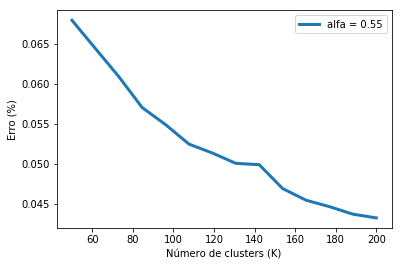

In [60]:
K = np.linspace(50,200,14)
plt.plot(K, calc_exp_error(error, 0.25), label='alfa = 0.55', linewidth = 3)
plt.ylabel('Erro (%)')
plt.xlabel('Número de clusters (K)')
plt.legend()
plt.show()

In [9]:
%%time
for new_data_len in [500]:
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1

    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    
    print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')

K=500, 0.0361
CPU times: user 3min 12s, sys: 2min 46s, total: 5min 59s
Wall time: 5min 59s


In [10]:
%%time
for new_data_len in [100]:
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1

    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    
    print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')

K=100, 0.0495
CPU times: user 40.5 s, sys: 41.2 ms, total: 40.6 s
Wall time: 40.7 s


In [62]:
%%time
training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
# training_set = np.hstack((train_set, np.resize(y_train, (x_train.shape[0], 1))))

for k in range(1,12):
    print(f'k = {k}, KNN error rate {kfolds(knn, training_set, 10, [k])}')
    
# k = 5 apresentou os melhores resultados

k = 1, KNN error rate (0.1, 0.035355339059327376)
k = 2, KNN error rate (0.12250000000000001, 0.05857687256929991)
k = 3, KNN error rate (0.06, 0.032015621187164243)
k = 4, KNN error rate (0.05750000000000001, 0.0225)
k = 5, KNN error rate (0.042499999999999996, 0.03363406011768428)
k = 6, KNN error rate (0.05750000000000001, 0.0317214438511238)
k = 7, KNN error rate (0.04, 0.03)
k = 8, KNN error rate (0.042499999999999996, 0.0275)
k = 9, KNN error rate (0.0475, 0.02839454172900137)
k = 10, KNN error rate (0.0475, 0.0343693177121688)
k = 11, KNN error rate (0.045000000000000005, 0.029154759474226504)
CPU times: user 4.27 s, sys: 5.66 ms, total: 4.28 s
Wall time: 4.27 s


In [208]:
%%timeit
training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
correct = 0

for i, sample in enumerate(x_test):
    sample = np.concatenate(sample)
    predicted = knn(training_set, sample, 4)
    if predicted == y_test[i]:
        correct += 1
        
print(f'success rate: {100*correct/len(x_test)}')

success rate: 94.74


In [69]:
%%time
knn_e = []

new_data_len = 120
print(f'K = {new_data_len}')
new_x_train_set = []
new_y_train_set = []
i = 0

with open(f'classes_{new_data_len}.yaml', 'r') as f:
    clustering = yaml.load(f)

for c in clustering:
    new_x_train_set.append(c.cluster_centers_)
    new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
    i += 1
#     plt.imshow(np.resize(new_x_train_set, (28, 28)))
new_x_train_set = np.concatenate(new_x_train_set)
new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))


training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
# training_set = np.hstack((train_set, np.resize(y_train, (x_train.shape[0], 1))))

#     print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')
#     print(f'K = {new_data_len}, k = 5, KNN error rate {kfolds(knn, training_set, 10, [5])}')
#     for k in range(1,12):
for k in range(1,12):
    e, var = kfolds(knn, training_set, 10, [k])
    print(f'\tk = {k}, KNN error rate {(e, var)}')
    knn_e.append(e)
print(knn_e)

K = 120
	k = 1, KNN error rate (0.04583333333333334, 0.017969882210706518)
	k = 2, KNN error rate (0.052500000000000005, 0.015833333333333335)
	k = 3, KNN error rate (0.02833333333333334, 0.014529663145135577)
	k = 4, KNN error rate (0.030000000000000006, 0.015898986690282425)
	k = 5, KNN error rate (0.029166666666666667, 0.013043729868748773)
	k = 6, KNN error rate (0.030833333333333334, 0.01902118701752221)
	k = 7, KNN error rate (0.029166666666666667, 0.017179606773406922)
	k = 8, KNN error rate (0.03333333333333334, 0.01536590742882148)
	k = 9, KNN error rate (0.03166666666666666, 0.017795130420052183)
	k = 10, KNN error rate (0.0325, 0.015567951410224504)
	k = 11, KNN error rate (0.03333333333333333, 0.013944333775567927)
[0.04583333333333334, 0.052500000000000005, 0.02833333333333334, 0.030000000000000006, 0.029166666666666667, 0.030833333333333334, 0.029166666666666667, 0.03333333333333334, 0.03166666666666666, 0.0325, 0.03333333333333333]
CPU times: user 57.1 s, sys: 230 ms, to

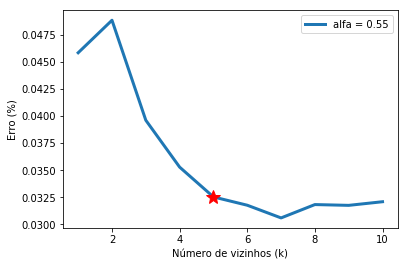

In [106]:
k = list(range(1,11))
plt.plot(k, calc_exp_error(knn_e, 0.55), label='alfa = 0.55', linewidth = 3)
plt.plot(5, calc_exp_error(knn_e, 0.55)[4], 'r*', markersize=15)
plt.ylabel('Erro (%)')
plt.xlabel('Número de vizinhos (k)')
plt.legend()
plt.savefig('knn_error.png')
plt.show()

In [104]:
error_eval_knn = calc_exp_error(knn_e, 0.55)

lst_e = error_eval_knn[0]
k = 1

for e in error_eval_knn[1:]:
    k += 1
    print(f'lst = {lst_e}, e = {e}')
    if abs(e-lst_e) < 0.05*lst_e:
        print(k)
    lst_e = e

lst = 0.04583333333333334, e = 0.04883333333333334
lst = 0.04883333333333334, e = 0.03960833333333334
lst = 0.03960833333333334, e = 0.03528458333333334
lst = 0.03528458333333334, e = 0.03253152083333334
lst = 0.03253152083333334, e = 0.03176733645833334
6
lst = 0.03176733645833334, e = 0.03059703505208334
7
lst = 0.03059703505208334, e = 0.03182836927864584
8
lst = 0.03182836927864584, e = 0.03175560310325521
9
lst = 0.03175560310325521, e = 0.03209058170679037
10


In [102]:
%%time
new_data_len = 120
    
mini_test = np.split(test_set, 10)
machine_error = []

for test in mini_test:
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1

    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
    #     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))

    e = evaluate_error(knn, training_set, test, [5])
    print(f'K={new_data_len}, {e}')
    machine_error.append(e)

K=120, 0.059
K=120, 0.068
K=120, 0.071
K=120, 0.073
K=120, 0.063
K=120, 0.039
K=120, 0.036
K=120, 0.014
K=120, 0.012
K=120, 0.05
CPU times: user 1min 47s, sys: 284 ms, total: 1min 47s
Wall time: 1min 47s


In [103]:
np.mean(machine_error)

0.0485